# Modeling Stock Prices and Portfolios prediction - Project#5

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***June, 2023***
* Instructor name: ***Abhineet Kulkarni***

# Business Problem
**We would like to invest some money into stock market and want to build a portfolio that will maximize returns with as little risk as possible. We therefore want to minimize the risk involved while maximizing the profit.**

# Analysis Approach
* This is a multi-step problem that can be divided as follows:
    * First step us to build models that can predict the stock prices. The idea is that      even though the model doesnt get the stock prices right, it should be able to            predict the ups and downs in the trend. We will try to use a couple of models and compare their performance:
        * First would be Vanilla LSTM model
        * Stacked LSTM model
        * ARIMA/GARCH models
    
    * Once we have a reliable model, we will generate predictions and then calculate returns on stocks and eventually build profitable portifolios.
    * We will use **Shapre Ratio** as one of measures to predict portfolios.
* One needs to include sentinet analysis as well to understand the effect of news and other factors on stocks price movement. However, at this point, we have not included it due to lack of time. 
* Other thing to include is the information contained in the SEC filings of the companies and incorporate ino models.

# Executive Summary
* To Be added once the project is complete

In [2]:
#Import all the needed libraries
import requests
import json
import os, sys, shutil,time
print(sys.executable)

# import basic libs
import pandas as pd
import numpy as np
import random
import math
import datetime

#import plotting libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

#import sklearn libs
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score,confusion_matrix, classification_report

#import statsmodels related stuff
import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

#import NN/Keras related libs

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.metrics import mean_absolute_percentage_error
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# stock related imports
import yfinance as yf
#import quandl
#import stocker as Stocker

from ta import add_all_ta_features 
from ta.utils import dropna
from arch import arch_model

from fastai.tabular.core import add_datepart
from finta import TA

#import warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/bin/python


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data Collection
* For now we will use the top 100 companies by weight listed in S&P. Below is the list of symbols that has to be used for downloading the data.

### Define the tickers (symbols) for the topmost 100 S&P500 companies:

* We may only use a few (topmost 10 companies by weight for now) for out current project. Later once the analysis is more solid, we can include all the 100 or 500 that can be used for portfolio prediction. The symbols and abbreviations can be found at the following link (https://www.slickcharts.com/sp500).

In [3]:
#S&P top 30 companies by weight
#https://www.slickcharts.com/sp500
SP500_top30 =['AAPL','MSFT', 'AMZN','NVDA','GOOGL','GOOG','TSLA','META','UNH','XOM','JNJ','JPM',\
             'JPM','V','LLY','PG','AVGO','MA','HD','CVX','MRK','PEP','KO','COST','PFE','WMT','MCD',\
              'BAC','CRM']#'ABBV'

## Yahoo Finance to Download the DATA
* We will use the yfinance library in Pythoin to download the data. Though Quandl provides more information on the data, it is not free anymore and is a paid service. 
* I chose a period of 16 years to look at the historical data

In [4]:
# period of 16 years from 12-31-2022 backwards go back to 01-04-2008
date_range = ('06-01-2012', '12-31-2022')
max_stocker = '05-31-2023'
INTERVAL = '1d'
min_date = datetime.datetime.strptime(date_range[0], "%m-%d-%Y")
max_date = datetime.datetime.strptime(max_stocker, "%m-%d-%Y")
#data  = yf.download(SP500_top30[0], start=min_date, end=max_date, interval=INTERVAL)
#data

In [5]:
tickers = SP500_top30[0:29]
tickerobjs = {} 
for ticker in tickers:
    tickerobjs[ticker] = yf.download(ticker, start=min_date, end=max_date, interval=INTERVAL)
    tickerobjs[ticker]= tickerobjs[ticker].reset_index(level=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Data Exploration, Cleaning and Feature Engineering

In [6]:
for i, (k, v) in enumerate(tickerobjs.items()):
    print(k, min(v['Date']), min(v['Adj Close']), max(v['Adj Close']))

AAPL 2012-06-01 00:00:00 12.02955150604248 180.4342803955078
MSFT 2012-06-01 00:00:00 21.642330169677734 338.3359375
AMZN 2012-06-01 00:00:00 10.41100025177002 186.57049560546875
NVDA 2012-06-01 00:00:00 2.6102921962738037 401.0684814453125
GOOGL 2012-06-01 00:00:00 13.990240097045898 149.8385009765625
GOOG 2012-06-01 00:00:00 13.92405891418457 150.70899963378906
TSLA 2012-06-01 00:00:00 1.7400000095367432 409.9700012207031
META 2012-06-01 00:00:00 17.729999542236328 382.17999267578125
UNH 2012-06-01 00:00:00 43.05183029174805 549.2251586914062
XOM 2012-06-01 00:00:00 26.33597755432129 117.32194519042969
JNJ 2012-06-01 00:00:00 45.55143737792969 179.75257873535156
JPM 2012-06-01 00:00:00 22.77521514892578 164.0157470703125
V 2012-06-01 00:00:00 25.964670181274414 247.30252075195312
LLY 2012-06-01 00:00:00 30.620298385620117 442.3800048828125
PG 2012-06-01 00:00:00 42.93048858642578 159.20980834960938
AVGO 2012-06-01 00:00:00 22.63102149963379 808.4230346679688
MA 2012-06-01 00:00:00 36

In [7]:
#tickerobjs['AAPL']= tickerobjs['AAPL'].reset_index(level=0)
tickerobjs['AAPL']

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-06-01,20.327143,20.451786,20.018572,20.035357,17.028904,520987600
1,2012-06-04,20.053572,20.267857,19.589287,20.153214,17.129080,556995600
2,2012-06-05,20.045357,20.231071,19.940357,20.101070,17.084755,388214400
3,2012-06-06,20.277500,20.494642,20.196428,20.409286,17.346724,401455600
4,2012-06-07,20.617500,20.618570,20.375000,20.418571,17.354620,379766800
...,...,...,...,...,...,...,...
2761,2023-05-23,173.130005,173.380005,171.279999,171.559998,171.559998,50747300
2762,2023-05-24,171.089996,172.419998,170.520004,171.839996,171.839996,45143500
2763,2023-05-25,172.410004,173.899994,171.690002,172.990005,172.990005,56058300
2764,2023-05-26,173.320007,175.770004,173.110001,175.429993,175.429993,54835000


### Adding Financial Indictors to the data
* We will add a few financial indicators to the data. For this we have used the python library **FINTA**(https://pypi.org/project/finta/).
    * Moving Averages (MA): Moving averages smooth out price data over a specific time period, providing a clearer view of the underlying trend. Common types include the Simple Moving Average (SMA) and the **Exponential Moving Average (EMA)**. We will use EMA.
    * **Relative Strength Index (RSI)**: RSI is a momentum oscillator that measures the speed and change of price movements. It helps identify overbought and oversold conditions, indicating potential reversals or trend continuations.
    * **Moving Average Convergence Divergence (MACD)**: MACD is a trend-following momentum indicator that shows the relationship between two moving averages. It provides signals for potential buy and sell opportunities when the lines cross or diverge. 
    * **Bollinger Bands**: Bollinger Bands consist of a moving average and upper and lower bands that represent the standard deviation from the moving average. They help identify periods of high or low volatility and potential price reversals.
    * **Average True Range (ATR)**: ATR measures the volatility of a stock or market by considering the range between high and low prices over a specific period. It helps assess potential price movements and set stop-loss levels.
    * **Ichimoku Cloud**: The Ichimoku Cloud is a comprehensive indicator that provides insights into support and resistance levels, trend direction, and momentum. It consists of various lines and a cloud area.

* Another library that we will use is **FASTAI**. This provides with a functionality *add_datepart* that adds features such as *year, month, week,day, day of the week, day of the month, day of the year* and a few others. For complete documentation please see this link(https://docs.fast.ai).

In [8]:
stocks_data = {}

for i, (ticker, stocker) in enumerate(tickerobjs.items()):
    #df = stocker.make_df(date_range[0], date_range[1])
    df = stocker
    # ddd date features
    add_datepart(df, 'Date', drop=False)
    df = df.rename(columns={"Open": "open", "Close": "close", "Low": "low", "High": "high","Volume": "volume"})
    ema = TA.EMA(df)
    bb  = TA.BBANDS(df)
    rsi = TA.RSI(df)
    macd = TA.MACD(df)
    atr  = TA.ATR(df)
    ichimoku = TA.ICHIMOKU(df)
    obv      = TA.OBV(df)
    # drop unwanted columns date feature columns
    df = df.drop(['Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'], axis=1)
    df['Is_month_end'] = df['Is_month_end'].astype(int)
    df['Is_month_start'] = df['Is_month_start'].astype(int)
    df['Exponential_moving_average'] = ema.copy()
    df = pd.concat([df, bb, rsi, macd, atr, ichimoku, obv], axis = 1)
    
    # setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    # sort df by date
    df = df.sort_index(ascending=True, axis=0)
    df = df.dropna()
    print(f"Nan Values: {ticker},{df.isna().sum().sum()}")
    
    stocks_data[ticker] = df

Nan Values: AAPL,0
Nan Values: MSFT,0
Nan Values: AMZN,0
Nan Values: NVDA,0
Nan Values: GOOGL,0
Nan Values: GOOG,0
Nan Values: TSLA,0
Nan Values: META,0
Nan Values: UNH,0
Nan Values: XOM,0
Nan Values: JNJ,0
Nan Values: JPM,0
Nan Values: V,0
Nan Values: LLY,0
Nan Values: PG,0
Nan Values: AVGO,0
Nan Values: MA,0
Nan Values: HD,0
Nan Values: CVX,0
Nan Values: MRK,0
Nan Values: PEP,0
Nan Values: KO,0
Nan Values: COST,0
Nan Values: PFE,0
Nan Values: WMT,0
Nan Values: MCD,0
Nan Values: BAC,0
Nan Values: CRM,0


In [9]:
(stocks_data["AAPL"].columns)

Index(['Date', 'open', 'high', 'low', 'close', 'Adj Close', 'volume', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE',
       'BB_LOWER', '14 period RSI', 'MACD', 'SIGNAL', '14 period ATR',
       'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU', 'OBV'],
      dtype='object')

In [10]:
type(stocks_data)#["AAPL"]

dict

In [11]:
def plot_stocks_columns(dict_df,col_name):
    plt.figure(figsize=(10, 5))
    for i, (ticker, df) in enumerate(dict_df.items()):
        plt.plot(df[col_name], linewidth=1, alpha=0.9, label=ticker)
        plt.legend()

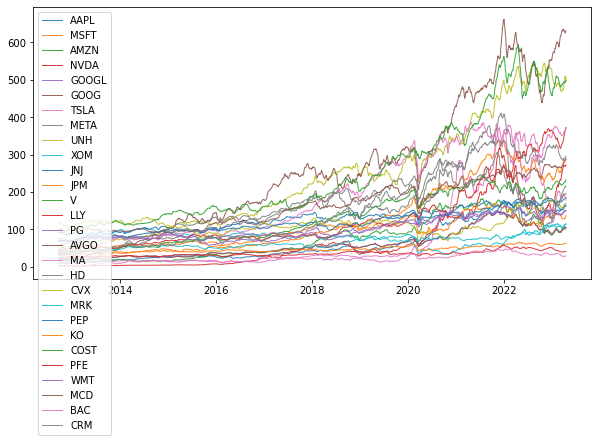

In [12]:
plot_stocks_columns(stocks_data,'Exponential_moving_average')
#plt.plot(stocks_data["AAPL"]['Exponential_moving_average'], linewidth=1, alpha=0.8, label="AAPL")

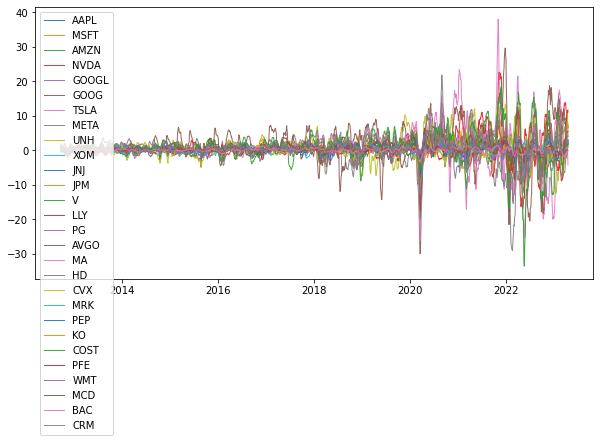

In [13]:
plot_stocks_columns(stocks_data,'MACD')

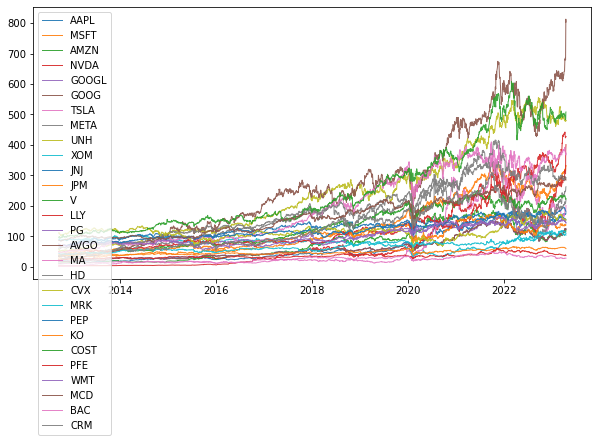

In [14]:
plot_stocks_columns(stocks_data,'CHIKOU')

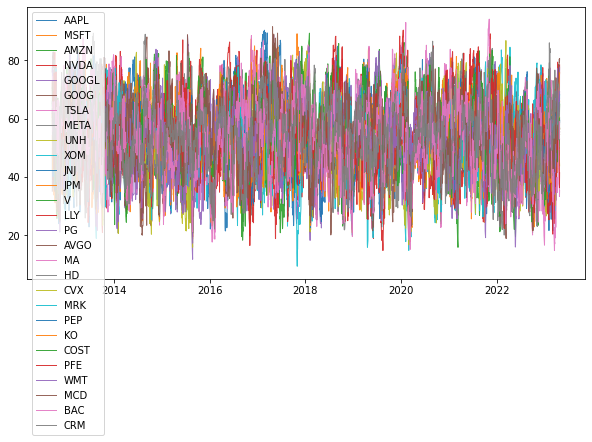

In [15]:
plot_stocks_columns(stocks_data,'14 period RSI')

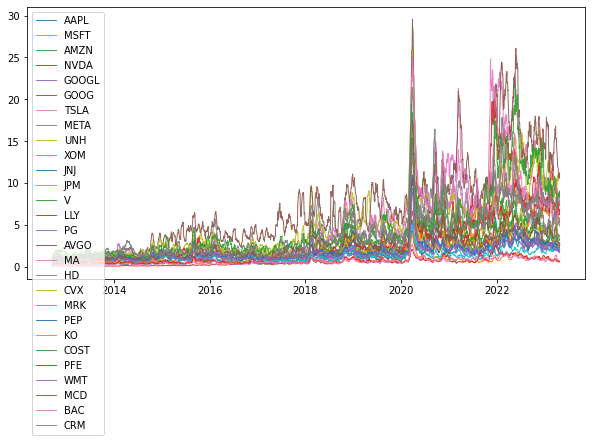

In [16]:
plot_stocks_columns(stocks_data,'14 period ATR')

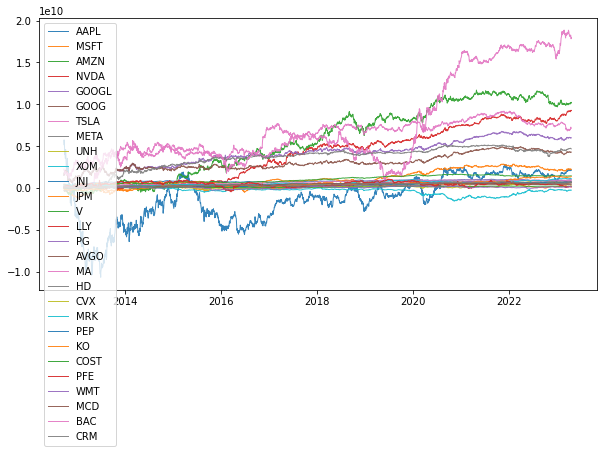

In [17]:
plot_stocks_columns(stocks_data,'OBV')

In [18]:
def correlation_matrix_plot(corr_df):
    fig, ax = plt.subplots(figsize=(20,8))
    Mask = np.triu(corr_df)
    sns.heatmap(corr_df, xticklabels=corr_df.columns, yticklabels=corr_df.columns,mask=Mask,\
                annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)
    #ax.grid(True)
    plt.title('Stocks Correlation')
    #ax1.set_xticks(np.arange(len(companies)))
    #ax1.set_yticks(np.arange(len(companies)))
    #ax1.set_xticklabels(companies,fontsize=10,rotation=90)
    #ax1.set_yticklabels(companies,fontsize=10)
    #ax1.set_alpha(0.4)
    ticks = np.arange(0,9,1)
    #plt.show()

In [20]:
float_df = stocks_data["AAPL"].select_dtypes(exclude = "object")
#float_df = float_df.drop(["Adj Close"], axis=1)
corr = float_df.corr()
#ax = plt.axes()
#matrix = np.triu(corr)
#fig, ax = plt.subplots(figsize=(20,8))
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, mask=matrix,annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)

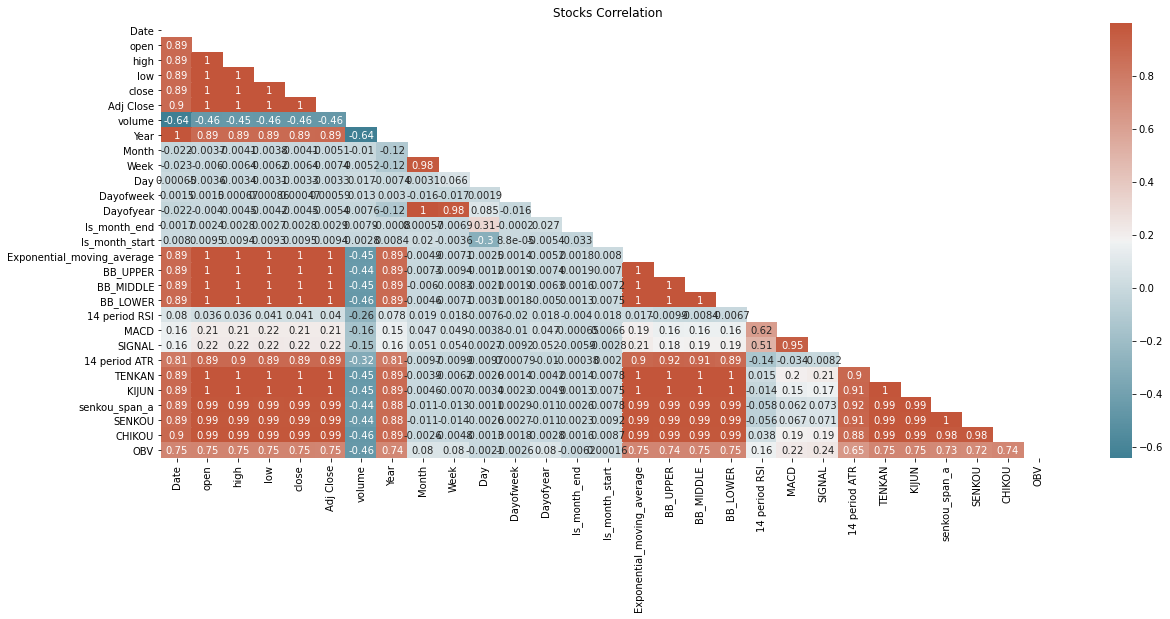

In [21]:
correlation_matrix_plot(corr)

In [22]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [23]:
upper

,Date,open,high,low,close,Adj Close,volume,Year,Month,Week,...,14 period RSI,MACD,SIGNAL,14 period ATR,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,OBV
Date,NaN,0.89458,0.894749,0.894830,0.894862,0.896951,-0.642369,0.995511,-0.021913,-0.022614,...,0.079822,0.157567,0.163878,0.809667,0.894576,0.893857,0.888970,0.886597,0.900164,0.748933
open,NaN,NaN,0.999870,0.999843,0.999664,0.999624,-0.456449,0.889055,-0.003653,-0.005991,...,0.036019,0.213389,0.222974,0.894155,0.999059,0.996854,0.987257,0.985560,0.988211,0.750087
high,NaN,NaN,NaN,0.999818,0.999843,0.999810,-0.454580,0.889267,-0.004129,-0.006429,...,0.035907,0.211116,0.220358,0.896129,0.999086,0.997013,0.987639,0.985954,0.988371,0.749877
low,NaN,NaN,NaN,NaN,0.999848,0.999808,-0.459150,0.889318,-0.003837,-0.006165,...,0.040873,0.216111,0.224332,0.891418,0.998866,0.996521,0.986865,0.985290,0.988534,0.750335
close,NaN,NaN,NaN,NaN,NaN,0.999962,-0.457052,0.889376,-0.004107,-0.006445,...,0.040867,0.213811,0.221784,0.893644,0.998817,0.996619,0.987177,0.985564,0.988543,0.750228
Adj Close,NaN,NaN,NaN,NaN,NaN,NaN,-0.458352,0.891545,-0.005089,-0.007422,...,0.039773,0.211820,0.219678,0.894201,0.998822,0.996689,0.987464,0.985963,0.988807,0.747580
volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.637425,-0.009994,-0.005162,...,-0.263026,-0.158296,-0.150736,-0.324228,-0.454038,-0.449718,-0.441347,-0.440402,-0.464521,-0.456910
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.116121,-0.115266,...,0.077563,0.152102,0.157934,0.805301,0.889068,0.888420,0.884153,0.881805,0.894489,0.736496
Month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978373,...,0.019375,0.046895,0.050871,-0.009660,-0.003914,-0.004556,-0.010928,-0.010879,-0.002552,0.079860
Week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018358,0.048920,0.053989,-0.009882,-0.006181,-0.007037,-0.013455,-0.013615,-0.004786,0.079555


In [24]:
print(to_drop)

['high', 'low', 'close', 'Adj Close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


In [25]:
(float_df.corr(method ='pearson'))

,Date,open,high,low,close,Adj Close,volume,Year,Month,Week,...,14 period RSI,MACD,SIGNAL,14 period ATR,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,OBV
Date,1.000000,0.894580,0.894749,0.894830,0.894862,0.896951,-0.642369,0.995511,-0.021913,-0.022614,...,0.079822,0.157567,0.163878,0.809667,0.894576,0.893857,0.888970,0.886597,0.900164,0.748933
open,0.894580,1.000000,0.999870,0.999843,0.999664,0.999624,-0.456449,0.889055,-0.003653,-0.005991,...,0.036019,0.213389,0.222974,0.894155,0.999059,0.996854,0.987257,0.985560,0.988211,0.750087
high,0.894749,0.999870,1.000000,0.999818,0.999843,0.999810,-0.454580,0.889267,-0.004129,-0.006429,...,0.035907,0.211116,0.220358,0.896129,0.999086,0.997013,0.987639,0.985954,0.988371,0.749877
low,0.894830,0.999843,0.999818,1.000000,0.999848,0.999808,-0.459150,0.889318,-0.003837,-0.006165,...,0.040873,0.216111,0.224332,0.891418,0.998866,0.996521,0.986865,0.985290,0.988534,0.750335
close,0.894862,0.999664,0.999843,0.999848,1.000000,0.999962,-0.457052,0.889376,-0.004107,-0.006445,...,0.040867,0.213811,0.221784,0.893644,0.998817,0.996619,0.987177,0.985564,0.988543,0.750228
Adj Close,0.896951,0.999624,0.999810,0.999808,0.999962,1.000000,-0.458352,0.891545,-0.005089,-0.007422,...,0.039773,0.211820,0.219678,0.894201,0.998822,0.996689,0.987464,0.985963,0.988807,0.747580
volume,-0.642369,-0.456449,-0.454580,-0.459150,-0.457052,-0.458352,1.000000,-0.637425,-0.009994,-0.005162,...,-0.263026,-0.158296,-0.150736,-0.324228,-0.454038,-0.449718,-0.441347,-0.440402,-0.464521,-0.456910
Year,0.995511,0.889055,0.889267,0.889318,0.889376,0.891545,-0.637425,1.000000,-0.116121,-0.115266,...,0.077563,0.152102,0.157934,0.805301,0.889068,0.888420,0.884153,0.881805,0.894489,0.736496
Month,-0.021913,-0.003653,-0.004129,-0.003837,-0.004107,-0.005089,-0.009994,-0.116121,1.000000,0.978373,...,0.019375,0.046895,0.050871,-0.009660,-0.003914,-0.004556,-0.010928,-0.010879,-0.002552,0.079860
Week,-0.022614,-0.005991,-0.006429,-0.006165,-0.006445,-0.007422,-0.005162,-0.115266,0.978373,1.000000,...,0.018358,0.048920,0.053989,-0.009882,-0.006181,-0.007037,-0.013455,-0.013615,-0.004786,0.079555


In [26]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=3)
pca_2 = PCA(n_components=5)
pca_3 = PCA(n_components=10)

principalComponents = pca_1.fit_transform(corr)
principalComponents = pca_2.fit_transform(corr)
principalComponents = pca_3.fit_transform(corr)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9644319741551257
0.9859395487430933
0.9998468835716592


In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [28]:
float_df

,Date,open,high,low,close,Adj Close,volume,Year,Month,Week,...,14 period RSI,MACD,SIGNAL,14 period ATR,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2012-09-20,2012-09-20,24.969999,25.002144,24.772142,24.953571,21.300169,336568400,2012,9,38,...,68.356715,0.566273,0.526688,0.380714,24.285536,23.781072,21.852411,21.198394,21.571428,5.175220e+09
2012-09-21,2012-09-21,25.086071,25.181070,24.977142,25.003214,21.342541,571589200,2012,9,38,...,68.890963,0.563805,0.534111,0.368010,24.304821,23.849463,21.953393,21.198394,21.261429,5.746810e+09
2012-09-24,2012-09-24,24.530714,24.825714,24.392857,24.671070,21.059031,639766400,2012,9,39,...,61.419220,0.529000,0.533089,0.384464,24.304821,23.997857,21.986429,21.373929,21.305000,5.107043e+09
2012-09-25,2012-09-25,24.580713,24.742144,24.035713,24.055000,20.533155,518789600,2012,9,39,...,50.482460,0.446647,0.515801,0.417704,24.608392,24.163928,22.173929,21.673036,20.600000,4.588254e+09
2012-09-26,2012-09-26,23.883572,24.024643,23.614286,23.756430,20.278296,576503200,2012,9,39,...,46.189747,0.353257,0.483292,0.428622,24.397678,24.163928,22.476786,21.977858,20.879286,4.011750e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,2023-04-17,165.089996,165.389999,164.029999,165.229996,165.001770,41516200,2023,4,16,...,62.420474,2.962638,3.132251,2.825715,163.309998,157.224998,149.725002,140.775002,171.559998,2.122728e+09
2023-04-18,2023-04-18,166.100006,167.410004,165.649994,166.470001,166.240067,49923000,2023,4,16,...,64.450551,3.019531,3.109707,2.802144,163.595001,157.555000,150.369999,140.775002,171.839996,2.172651e+09
2023-04-19,2023-04-19,165.800003,168.160004,165.539993,167.630005,167.398468,47720200,2023,4,16,...,66.285397,3.122230,3.112212,2.746429,163.970001,159.040001,150.369999,140.775002,172.990005,2.220371e+09


In [29]:
# define number of features to keep
k = 10
# perform feature selection
X = float_df.drop(['Adj Close','Date'],  axis=1)
y = float_df["Adj Close"]
X_new = SelectKBest(f_regression, k=k).fit_transform(X, y)
# get feature names of selected features
selected_features = X.columns[SelectKBest(f_regression, k=k).fit(X, y).get_support()]
# print selected features

print(selected_features)

Index(['open', 'high', 'low', 'close', 'Exponential_moving_average',
       'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'TENKAN', 'KIJUN'],
      dtype='object')


In [30]:
print(to_drop)

['high', 'low', 'close', 'Adj Close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


In [31]:
stocks_data["AAPL"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2012-09-20 to 2023-04-21
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        2658 non-null   datetime64[ns]
 1   open                        2658 non-null   float64       
 2   high                        2658 non-null   float64       
 3   low                         2658 non-null   float64       
 4   close                       2658 non-null   float64       
 5   Adj Close                   2658 non-null   float64       
 6   volume                      2658 non-null   int64         
 7   Year                        2658 non-null   int32         
 8   Month                       2658 non-null   int32         
 9   Week                        2658 non-null   int32         
 10  Day                         2658 non-null   int32         
 11  Dayofweek                   2658 non-n

# ARCH+ GARCH Models

In [32]:
#data_diff = data.diff().dropna()
#data_diff
tickerobjs['AAPL']

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2012-06-01,20.327143,20.451786,20.018572,20.035357,17.028904,520987600,2012,6,22,1,4,153,False,True,False,False,False,False,1.338509e+09
1,2012-06-04,20.053572,20.267857,19.589287,20.153214,17.129080,556995600,2012,6,23,4,0,156,False,False,False,False,False,False,1.338768e+09
2,2012-06-05,20.045357,20.231071,19.940357,20.101070,17.084755,388214400,2012,6,23,5,1,157,False,False,False,False,False,False,1.338854e+09
3,2012-06-06,20.277500,20.494642,20.196428,20.409286,17.346724,401455600,2012,6,23,6,2,158,False,False,False,False,False,False,1.338941e+09
4,2012-06-07,20.617500,20.618570,20.375000,20.418571,17.354620,379766800,2012,6,23,7,3,159,False,False,False,False,False,False,1.339027e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,2023-05-23,173.130005,173.380005,171.279999,171.559998,171.559998,50747300,2023,5,21,23,1,143,False,False,False,False,False,False,1.684800e+09
2762,2023-05-24,171.089996,172.419998,170.520004,171.839996,171.839996,45143500,2023,5,21,24,2,144,False,False,False,False,False,False,1.684886e+09
2763,2023-05-25,172.410004,173.899994,171.690002,172.990005,172.990005,56058300,2023,5,21,25,3,145,False,False,False,False,False,False,1.684973e+09
2764,2023-05-26,173.320007,175.770004,173.110001,175.429993,175.429993,54835000,2023,5,21,26,4,146,False,False,False,False,False,False,1.685059e+09


* Function to add log returns

In [33]:
def add_log_return(df):
        df.loc[df.index, 'LogRets'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
        df.loc[df.index[0], 'LogRets'] = 0
        df.loc[df.index, 'CumLogRets'] = df['LogRets'].cumsum()
        df.loc[df.index, 'CumRets']   = np.exp(df['CumLogRets'])

In [34]:
ticker_diff = {} 
ticker_logs = {}
for i, (ticker, stocker) in enumerate(tickerobjs.items()):
    df = stocker
    df= df.drop(columns=['Is_month_end','Is_month_start','Is_quarter_end',\
                         'Is_quarter_start','Is_year_end','Is_year_start',\
                         'Month','Week','Day','Dayofweek','Dayofyear','Elapsed'], axis=1)
    df.set_index("Date", inplace=True)
    df_log = df.copy()
    df_diff = df.diff().dropna()
    add_log_return(df_log)
    #df_diff.set_index("Date", inplace=True)
    #df_diff.index = df_diff.index.to_period("D")
    ticker_diff[ticker]= df_diff
    ticker_logs[ticker] = df_log

In [35]:
ticker_diff['AAPL']

,Open,High,Low,Close,Adj Close,Volume,Year
Date,,,,,,,
2012-06-04,-0.273571,-0.183929,-0.429285,0.117857,0.100176,36008000.0,0.0
2012-06-05,-0.008215,-0.036785,0.351070,-0.052143,-0.044325,-168781200.0,0.0
2012-06-06,0.232143,0.263571,0.256071,0.308216,0.261969,13241200.0,0.0
2012-06-07,0.340000,0.123928,0.178572,0.009285,0.007896,-21688800.0,0.0
2012-06-08,-0.203215,0.116430,-0.053572,0.307142,0.261049,-32250400.0,0.0
...,...,...,...,...,...,...,...
2023-05-23,-0.849991,-1.330002,-2.169998,-2.639999,-2.639999,7176400.0,0.0
2023-05-24,-2.040009,-0.960007,-0.759995,0.279999,0.279999,-5603800.0,0.0
2023-05-25,1.320007,1.479996,1.169998,1.150009,1.150009,10914800.0,0.0


In [36]:
ticker_logs['AAPL']

,Open,High,Low,Close,Adj Close,Volume,Year,LogRets,CumLogRets,CumRets
Date,,,,,,,,,,
2012-06-01,20.327143,20.451786,20.018572,20.035357,17.028904,520987600,2012,0.000000,0.000000,1.000000
2012-06-04,20.053572,20.267857,19.589287,20.153214,17.129080,556995600,2012,0.005865,0.005865,1.005883
2012-06-05,20.045357,20.231071,19.940357,20.101070,17.084755,388214400,2012,-0.002591,0.003274,1.003280
2012-06-06,20.277500,20.494642,20.196428,20.409286,17.346724,401455600,2012,0.015217,0.018492,1.018664
2012-06-07,20.617500,20.618570,20.375000,20.418571,17.354620,379766800,2012,0.000455,0.018947,1.019127
...,...,...,...,...,...,...,...,...,...,...
2023-05-23,173.130005,173.380005,171.279999,171.559998,171.559998,50747300,2023,-0.015271,2.310021,10.074635
2023-05-24,171.089996,172.419998,170.520004,171.839996,171.839996,45143500,2023,0.001631,2.311652,10.091078
2023-05-25,172.410004,173.899994,171.690002,172.990005,172.990005,56058300,2023,0.006670,2.318322,10.158611


In [37]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import scipy.stats as scs

### Stationarity Test
#### Original Series Stationarity Check

In [38]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)

    plot_acf(series, zero = False, lags = 90, ax = axes[0])
    plot_pacf(series, zero = False, lags = 90, ax = axes[1])

    plt.show()

In [39]:
def tsplot(series, lags=30, figsize=(10, 8), style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        y = series
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout  = (2, 2)
        #ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax  = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        qq_ax   = plt.subplot2grid(layout, (1, 0))
        pp_ax   = plt.subplot2grid(layout, (1, 1))
        
        #y.plot(ax=ts_ax)
        #ts_ax.plot()
        #ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, zero = False, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, zero= False, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

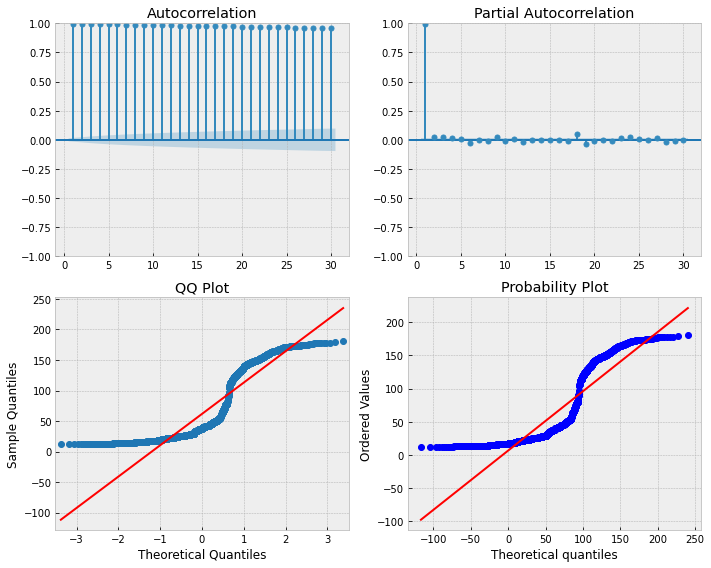

In [40]:
tsplot(ticker_logs['AAPL']['Adj Close'], lags=30)

## Transformation Techniques
Clearly this series is Non-Stationary. So before applying the ARIMA Models, we tranform this series to Stationary using the following transofrmations.
* **Log Transformation:** Taking the log of each data point will dampen the effect of variance over time
* **Differencing:** Taking the difference between consecutive data points usually removes the trend changes over time.
* **Log Tranformation followed by Differencing:** This technique removes both mean and variance changes over time.
To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.

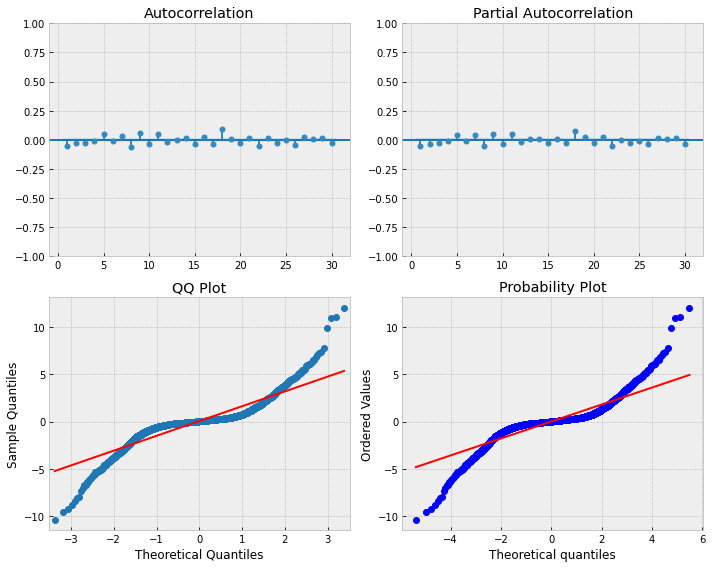

In [41]:
tsplot(ticker_diff['AAPL']['Adj Close'], lags=30)

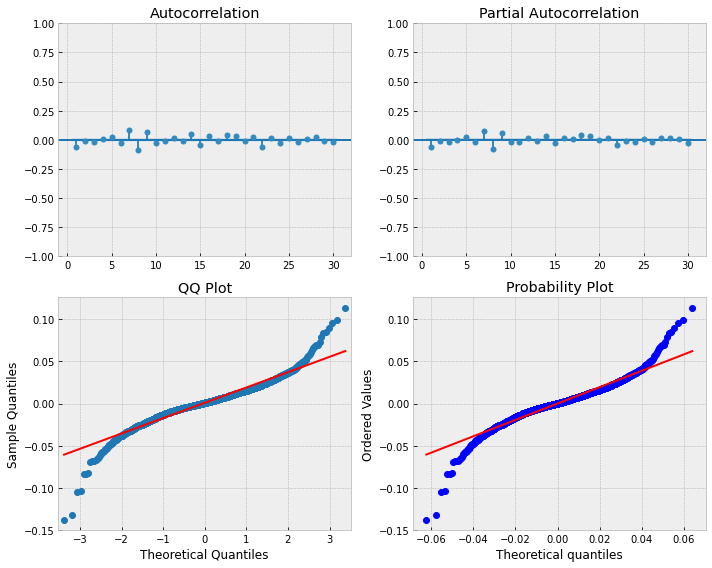

In [42]:
tsplot(ticker_logs['AAPL']['LogRets'], lags=30)

In [43]:
def print_adfuller_test(series):
    significance=.05
    results = adfuller(series,autolag='AIC')
    dfresults = pd.Series(results[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key,value in results[4].items():
        dfresults['Critical Value (%s)'%key] = value
        
    print('Augmented Dickey-Fuller Test Results:')
    print(dfresults)    
    if(results[1])<0.05:
        print ("Series is stationary")
    else:
        print ("Series is *NOT* stationary")

In [44]:
print_adfuller_test(ticker_logs['AAPL']['LogRets'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.684041e+01
P-Value                 1.139290e-29
# Lags Used             8.000000e+00
# Observations Used     2.757000e+03
Critical Value (1%)    -3.432724e+00
Critical Value (5%)    -2.862589e+00
Critical Value (10%)   -2.567328e+00
dtype: float64
Series is stationary


In [45]:
print_adfuller_test(ticker_diff['AAPL']['Adj Close'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.090498e+01
P-Value                 1.134114e-19
# Lags Used             2.100000e+01
# Observations Used     2.743000e+03
Critical Value (1%)    -3.432736e+00
Critical Value (5%)    -2.862594e+00
Critical Value (10%)   -2.567331e+00
dtype: float64
Series is stationary


In [46]:
print_adfuller_test(ticker_logs['AAPL']['Adj Close'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         0.646703
P-Value                    0.988712
# Lags Used               22.000000
# Observations Used     2743.000000
Critical Value (1%)       -3.432736
Critical Value (5%)       -2.862594
Critical Value (10%)      -2.567331
dtype: float64
Series is *NOT* stationary


In [47]:
#import pmdarima

def fit_arima(series, range_p=range(0, 6), range_q=range(0, 6)):
    final_order = (0, 0, 0)
    best_aic = np.inf
    arima = sm.tsa.statespace.SARIMAX(series, order=final_order,seasonal_order=final_order,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    for p in range_p:
        for q in range_q:
            if (p==0) and (q==0):
                next
            arima.order = (p, 0, q)
            arima.fit(series)

            aic = arima.aic()

            if aic < best_aic:
                best_aic = aic
                final_order = (p, 0, q)
                
    arima.order=final_order
    return arima.fit(series)

In [48]:
 def add_log_return(df):
        df.loc[df.index, 'LogRets'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
        df.loc[df.index[0], 'LogRets'] = 0
        df.loc[df.index, 'CumLogRets'] = df['LogRets'].cumsum()
        df.loc[df.index, 'CumRets']   = np.exp(df['CumLogRets'])

In [49]:
#arima = fit_arima(ticker_logs['AAPL']['LogRets'])
logrets = ticker_logs['AAPL']['LogRets']
#logrets = ticker_logs['AAPL']['Adj Close']
logrets = logrets.fillna(logrets.bfill())

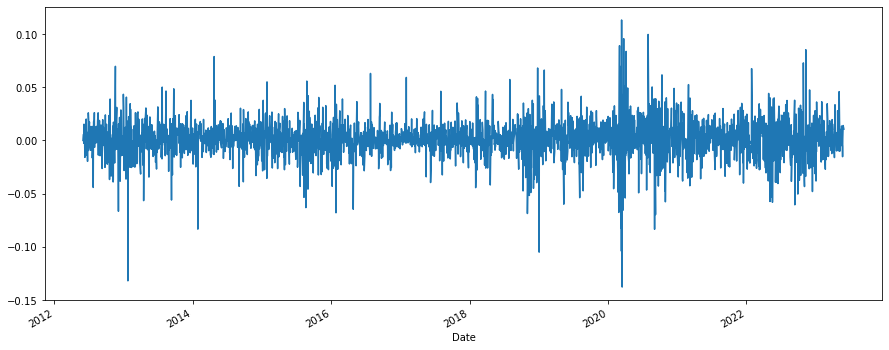

Date
2012-06-01    0.000000
2012-06-04    0.005865
2012-06-05   -0.002591
2012-06-06    0.015217
2012-06-07    0.000455
Name: LogRets, dtype: float64


In [50]:
logrets.plot(figsize=(15, 6))
plt.show()
print(logrets.head())

In [51]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(logrets,order=comb,seasonal_order=combs,enforce_stationarity=False,\
                                            enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 4): AIC Calculated=-14308.971406360313
ARIMA (0, 0, 0) x (0, 0, 1, 4): AIC Calculated=-14283.205748929937
ARIMA (0, 0, 0) x (0, 1, 0, 4): AIC Calculated=-12388.57019178494
ARIMA (0, 0, 0) x (0, 1, 1, 4): AIC Calculated=-14243.424996107642
ARIMA (0, 0, 0) x (1, 0, 0, 4): AIC Calculated=-14289.374826281884
ARIMA (0, 0, 0) x (1, 0, 1, 4): AIC Calculated=-14282.124009529149
ARIMA (0, 0, 0) x (1, 1, 0, 4): AIC Calculated=-13004.378438311333
ARIMA (0, 0, 0) x (1, 1, 1, 4): AIC Calculated=-14239.618279405666
ARIMA (0, 0, 1) x (0, 0, 0, 4): AIC Calculated=-14309.462061895285
ARIMA (0, 0, 1) x (0, 0, 1, 4): AIC Calculated=-14284.203238670641
ARIMA (0, 0, 1) x (0, 1, 0, 4): AIC Calculated=-12391.17810031319
ARIMA (0, 0, 1) x (0, 1, 1, 4): AIC Calculated=-14244.58893598233
ARIMA (0, 0, 1) x (1, 0, 0, 4): AIC Calculated=-14295.944458399215
ARIMA (0, 0, 1) x (1, 0, 1, 4): AIC Calculated=-14282.633628025564
ARIMA (0, 0, 1) x (1, 1, 0, 4): AIC Calculated=-13029.09141685831

In [52]:
#add_log_return(testdf)
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq        (1, 0, 0)
pdqs    (0, 0, 0, 4)
aic    -14315.434911
Name: 32, dtype: object

In [53]:
#testdf
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(logrets, 
                                        order=(1, 0, 0), 
                                        seasonal_order=(0, 0, 0, 4), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0553      0.012     -4.491      0.000      -0.079      -0.031
sigma2         0.0003   4.84e-06     68.117      0.000       0.000       0.000


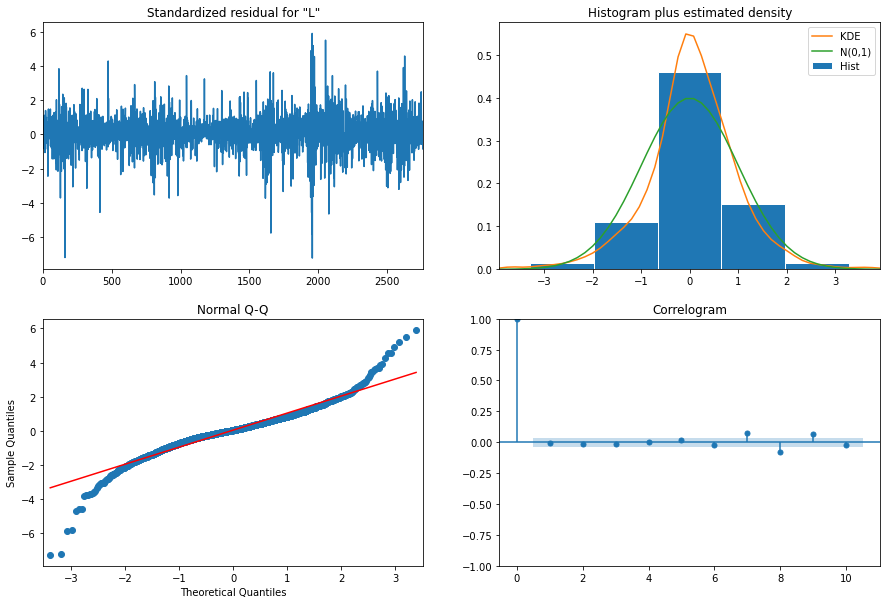

In [54]:
output.plot_diagnostics(figsize=(15, 10))
plt.show()

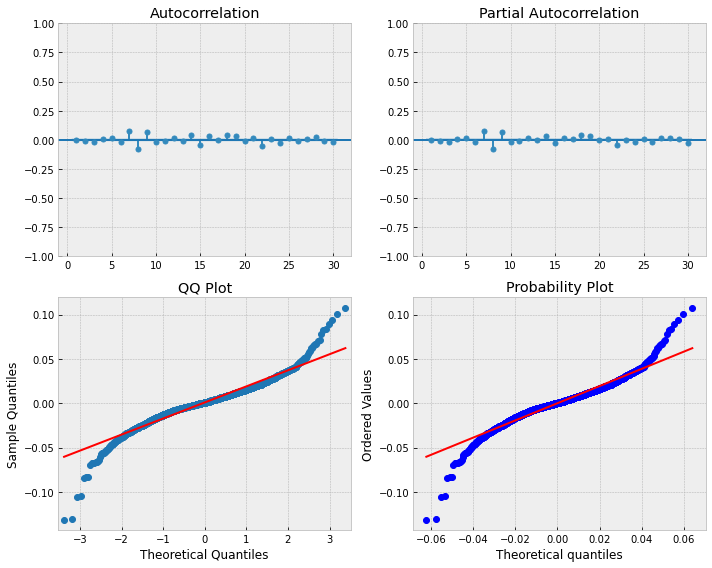

In [55]:
#p(mdl.summary())
tsplot(output.resid, lags=30)

In [56]:
sm.tsa.ARIMA

statsmodels.tsa.arima.model.ARIMA

In [57]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = np.arange(5) # [0,1,2,3,4]
    d_rng = np.arange(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = sm.tsa.ARIMA(TS, order=(i,d,j)).fit()
                        #method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i,d,j))) 
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


TS = logrets
res_tup = _get_best_model(TS)


aic: -14319.15273 | order: (0, 0, 0)
aic: -14326.49452 | order: (0, 0, 1)
aic: -14324.66634 | order: (0, 0, 2)
aic: -14323.22447 | order: (0, 0, 3)
aic: -14321.52751 | order: (0, 0, 4)
aic: -12243.80782 | order: (0, 1, 0)
aic: -14304.72458 | order: (0, 1, 1)
aic: -14311.99342 | order: (0, 1, 2)
aic: -14310.11721 | order: (0, 1, 3)
aic: -14308.73844 | order: (0, 1, 4)
aic: -14326.33174 | order: (1, 0, 0)
aic: -14324.75929 | order: (1, 0, 1)
aic: -14322.78930 | order: (1, 0, 2)
aic: -14321.31890 | order: (1, 0, 3)
aic: -14319.50253 | order: (1, 0, 4)
aic: -13130.47291 | order: (1, 1, 0)
aic: -14311.83296 | order: (1, 1, 1)
aic: -14300.80832 | order: (1, 1, 2)
aic: -14314.35007 | order: (1, 1, 3)
aic: -14311.63418 | order: (1, 1, 4)
aic: -14324.58091 | order: (2, 0, 0)
aic: -14322.60649 | order: (2, 0, 1)
aic: -14320.87287 | order: (2, 0, 2)
aic: -14319.31835 | order: (2, 0, 3)
aic: -14317.51044 | order: (2, 0, 4)
aic: -13466.44751 | order: (2, 1, 0)
aic: -14309.88472 | order: (2, 1, 1)
a

In [58]:
#best_model = sm.tsa.ARIMA(TS, order=(4,0,4)).fit()
#tsplot(best_model.resid, lags=30)
best_order =res_tup[1]
pval = int(best_order[0])
oval = int(best_order[1])
qval = int(best_order[2])
print(pval,oval,qval)
# Using student T distribution usually provides better fit
am = arch_model(output.resid, p=pval, o=oval, q=qval, power=1.0, dist='StudentsT')#, p=p_, o=o_, q=q_)# dist='studentst')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

4 1 3
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:                7569.88
Distribution:      Standardized Student's t   AIC:                          -15117.8
Method:                  Maximum Likelihood   BIC:                          -15052.6
                                              No. Observations:                 2766
Date:                      Tue, Jun 27 2023   Df Residuals:                     2765
Time:                              11:22:11   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------------

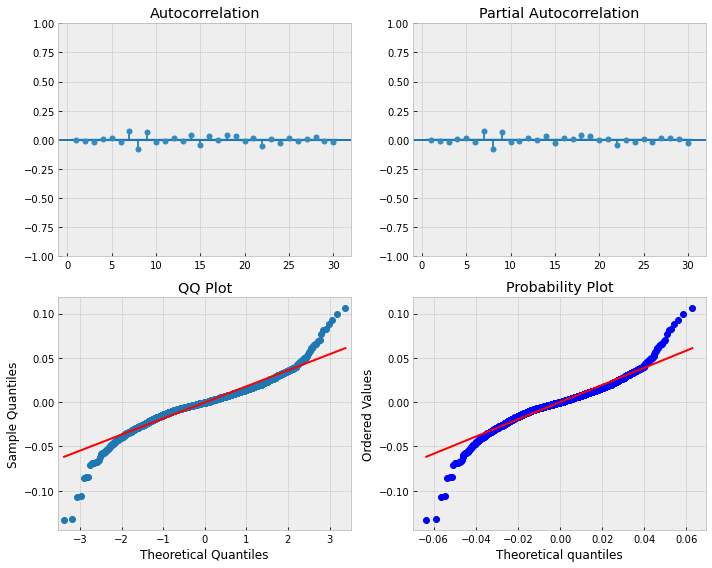

In [59]:
tsplot(res.resid, lags=30)

In [63]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res.forecast(start=pd.to_datetime('2023-06-01'))
#pred_conf = pred.conf_int()